# Tutorial with 1d advection equation

Jiawei Zhuang
7/24/2019

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__

('1.13.1', '2.2.4-tf')

In [2]:
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Define simulation grids

In [3]:
# we mostly run simulation on coarse grid
# the fine grid is only for obtaining training data and generate the reference "truth"

grid_length = 256
fine_grid_resolution = 256
coarse_grid_resolution = 32

assert fine_grid_resolution % coarse_grid_resolution == 0


In [4]:
# 1d domain, so only 1 point along y dimension

fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )

coarse_grid = grids.Grid(
    size_x=coarse_grid_resolution, size_y=1, 
    step=grid_length/coarse_grid_resolution
    )

x_fine, _ = fine_grid.get_mesh()
x_coarse, _ = coarse_grid.get_mesh()

x_fine.shape, x_coarse.shape

((256, 1), (32, 1))

# Generate initial condition

In [0]:
def make_square(x, height=1.0, center=0.25, width=0.1):
  """
  Args:
    x: Numpy array. Shape should be (nx, 1) or (nx,)
    height: float, peak concentration
    center: float, relative center position in 0~1
    width: float, relative width in 0~0.5

  Returns:
    Numpy array, same shape as `x`
  """
  nx = x.shape[0]
  c = np.zeros_like(x)
  c[int((center-width)*nx):int((center+width)*nx)] = height
  return c

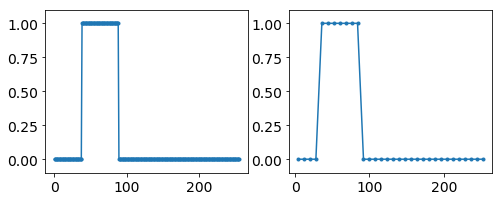

In [0]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].plot(x_fine, make_square(x_fine), marker='.')
axes[1].plot(x_coarse, make_square(x_coarse), marker='.')

for ax in axes:
  ax.set_ylim(-0.1, 1.1)

In [0]:
def make_multi_square(x, height_list, width_list):
  c_list = []
  for height in height_list:
    for width in width_list:
      c_temp = make_square(x, height=height, width=width)
      c_list.append(c_temp)

  return np.array(c_list)

height_list = np.arange(0.1, 1.1, 0.1)
width_list = np.arange(1/16, 1/4, 1/16)  # width is chosen so that coarse-graining of square wave is symmetric

c_init = make_multi_square(
  x_coarse,
  height_list = height_list,
  width_list = width_list
)

c_init.shape  # (sample, x, y)

(30, 32, 1)

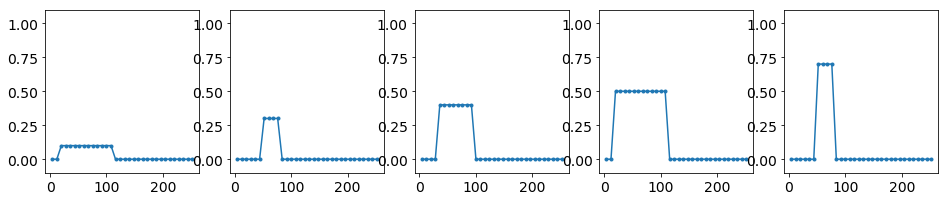

In [0]:
fig, axes = plt.subplots(1, 5, figsize=[16, 3])

for i, ax in enumerate(axes):
  ax.plot(x_coarse, c_init[4*i+2, :, 0], marker='.')
  ax.set_ylim(-0.1, 1.1)

# Wrap with velocity fields

In [0]:
# for simplicity, use uniform constant velocity field for all samples

initial_state = {
    'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init.shape, np.float32)
}

for k, v in initial_state.items():
  print(k, v.shape)   # (sample, x, y)

concentration (30, 32, 1)
x_velocity (30, 32, 1)
y_velocity (30, 32, 1)


# Run baseline advection solver

In [0]:
# first-order finite difference model, very diffusive
model_1st = models.FiniteDifferenceModel(
    advection_equations.UpwindAdvection(cfl_safety_factor=0.5), 
    coarse_grid
    )

# second-order scheme with monotonic flux limiter
model_2nd = models.FiniteDifferenceModel(
    advection_equations.VanLeerAdvection(cfl_safety_factor=0.5), 
    coarse_grid
    )

In [0]:
time_steps = np.arange(0, 128+1)

In [0]:
%time integrated_1st = integrate.integrate_steps(model_1st, initial_state, time_steps)
%time integrated_2nd = integrate.integrate_steps(model_2nd, initial_state, time_steps)

CPU times: user 322 ms, sys: 12.2 ms, total: 334 ms
Wall time: 345 ms
CPU times: user 1.33 s, sys: 25.6 ms, total: 1.35 s
Wall time: 1.37 s


In [0]:
for k, v in integrated_1st.items():
  print(k, v.shape)   # (time, sample, x, y)

concentration (129, 30, 32, 1)
x_velocity (129, 30, 32, 1)
y_velocity (129, 30, 32, 1)


In [0]:
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

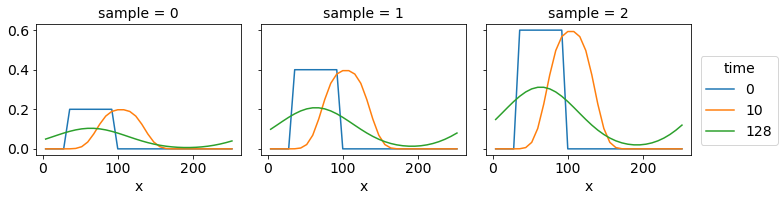

In [0]:
dr_1st = wrap_as_xarray(integrated_1st)
dr_1st.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')

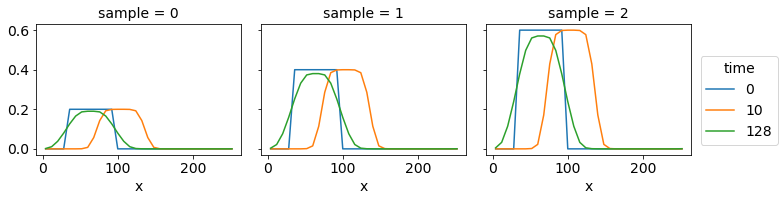

In [0]:
dr_2nd = wrap_as_xarray(integrated_2nd)
dr_2nd.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')

# Run untrained neural net model

In [0]:
model_nn = models.PseudoLinearModel(
    advection_equations.FiniteVolumeAdvection(0.5), 
    coarse_grid,
    num_time_steps=4,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    learned_keys = {'concentration_edge_x', 'concentration_edge_y'},  # finite volume view, use edge concentration
    activation='relu',
)

model_nn.learned_keys, model_nn.fixed_keys

({'concentration_edge_x', 'concentration_edge_y'},
 {'concentration', 'x_velocity', 'y_velocity'})

In [0]:
tf.random.set_random_seed(0)

%time integrated_untrained = integrate.integrate_steps(model_nn, initial_state, time_steps)

CPU times: user 2.17 s, sys: 112 ms, total: 2.29 s
Wall time: 2.22 s


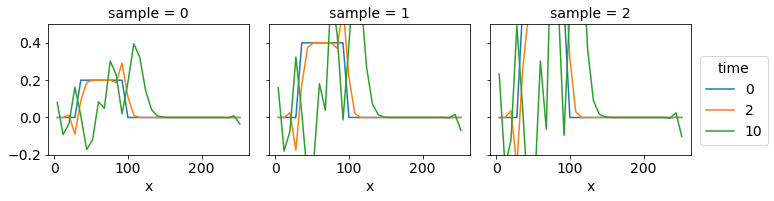

In [0]:
(wrap_as_xarray(integrated_untrained)
.isel(time=[0, 2, 10], sample=[4, 10, 16])
.plot(col='sample', hue='time', ylim=[-0.2, 0.5])
)
# untrained model is diverging! 

In [0]:
# weights are initialized at the first model call
len(model_nn.get_weights())

8

In [0]:
model_nn.get_weights()[0].shape # first convolutional filter, (x, y, input_channel, filter_channel) 

(3, 1, 3, 32)

In [0]:
model_nn.get_weights()[2].shape # second convolutional filter, (x, y, filter_channel, filter_channel) 

(3, 1, 32, 32)

# Generate training data from high-resolution baseline simulations

In [0]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=128):

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.5)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


def make_train_data(integrated_coarse, coarse_time_steps=128, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

In [0]:
# need to re-evaluate initial condition on high-resolution grid

c_init_fine = make_multi_square(
  x_fine,
  height_list = height_list,
  width_list = width_list
)

initial_state_fine = {
    'concentration': c_init_fine.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_fine.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_fine.shape, np.float32)
}

%time integrated_ref = reference_solution(initial_state_fine, fine_grid, coarse_grid)
train_input, train_output = make_train_data(integrated_ref)

CPU times: user 12 s, sys: 118 ms, total: 12.1 s
Wall time: 12.2 s

 train_input shape:
concentration (3750, 32, 1)
x_velocity (3750, 32, 1)
y_velocity (3750, 32, 1)

 train_output shape: (3750, 4, 32, 1)


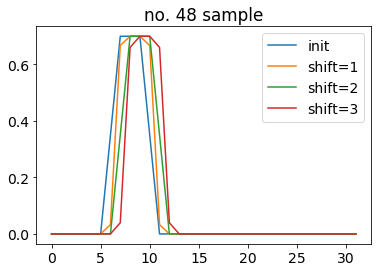

In [0]:
# make sure that single-step input corresponds to multi-step (advected) output

i_sample = 48  # any number between 0 and train_output.shape[0]

plt.plot(train_input['concentration'][i_sample].numpy(), label='init')
for shift in range(train_output.shape[1])[:3]:
  plt.plot(train_output[i_sample, shift].numpy(), label=f'shift={shift+1}')

plt.title(f'no. {i_sample} sample')
plt.legend()

# Train neural net model

In [0]:
%%time 
# same as training standard Keras model
model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001 * 1), loss='mae',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

tf.random.set_random_seed(42)
np.random.seed(42)
history = model_nn.fit(
    train_input, train_output, epochs=80, batch_size=32, 
    verbose=1, shuffle=True
    )

Train on 3750 samples
Epoch 1/80
3750/3750 [==============================] - 7s 2ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0253
Epoch 2/80
3750/3750 [==============================] - 2s 553us/sample - loss: 0.0017 - root_mean_squared_error: 0.0050
Epoch 3/80
3750/3750 [==============================] - 2s 525us/sample - loss: 0.0013 - root_mean_squared_error: 0.0042
Epoch 4/80
3750/3750 [==============================] - 2s 536us/sample - loss: 0.0011 - root_mean_squared_error: 0.0038
Epoch 5/80
3750/3750 [==============================] - 2s 577us/sample - loss: 0.0011 - root_mean_squared_error: 0.0037
Epoch 6/80
3750/3750 [==============================] - 2s 568us/sample - loss: 0.0010 - root_mean_squared_error: 0.0036
Epoch 7/80
3750/3750 [==============================] - 2s 591us/sample - loss: 0.0010 - root_mean_squared_error: 0.0035
Epoch 8/80
3750/3750 [==============================] - 2s 534us/sample - loss: 9.3966e-04 - root_mean_squared_error: 0.0034
Epoch 9/

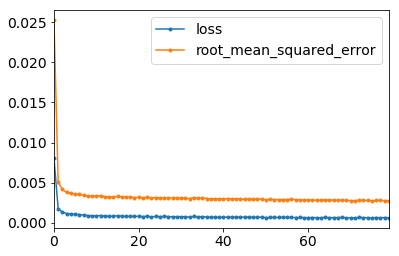

In [0]:
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')

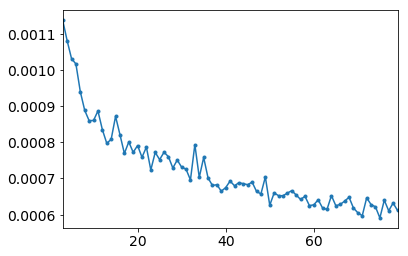

In [0]:
df_history['loss'][3:].plot(marker='.')
# might not converged yet

# Integrate trained model

In [0]:
%time integrated_nn = integrate.integrate_steps(model_nn, initial_state, time_steps)

CPU times: user 2.08 s, sys: 78.4 ms, total: 2.15 s
Wall time: 2.08 s


In [0]:
dr_nn = wrap_as_xarray(integrated_nn)
dr_nn.sizes

Frozen(OrderedDict([('time', 129), ('sample', 30), ('x', 32)]))

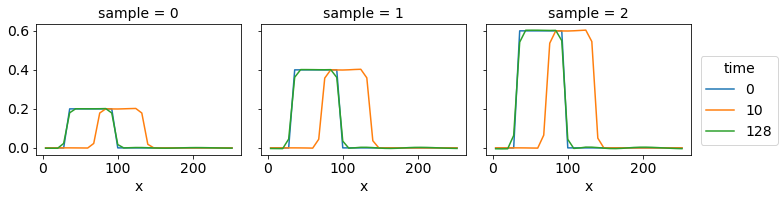

In [0]:
dr_nn.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')
# much better than traditional finite difference scheme

# Evaluate accuracy

Here just test on training data. You can also make new test data.

In [0]:
dr_ref = wrap_as_xarray(integrated_ref)  # reference "truth"

dr_all = xarray.concat([dr_nn, dr_2nd, dr_1st, dr_ref], dim='model')
dr_all.coords['model'] = ['nn', '2nd', '1st', 'ref']

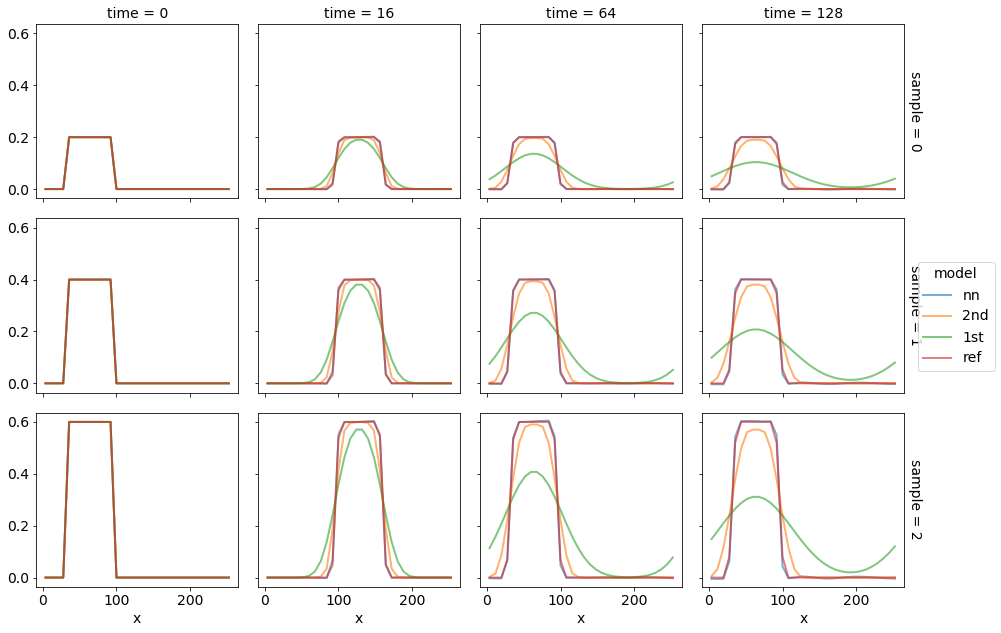

In [0]:
(dr_all.isel(time=[0, 16, 64, 128], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)
# neural net model (blue line) almost overlaps with reference truth (red line); so lines are hard to see clearly

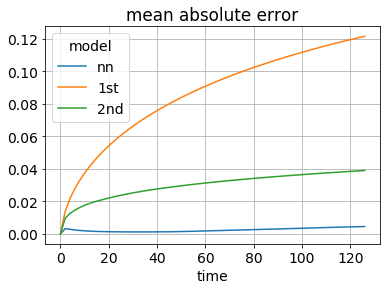

In [0]:
(
  (dr_all.sel(model=['nn', '1st', '2nd']) - dr_all.sel(model='ref'))
  .pipe(abs).mean(dim=['x', 'sample'])  # mean absolute error
  .isel(time=slice(0, -1, 2))  # the original error series oscillates between odd & even steps, because CFL=0.5
  .plot(hue='model')
)
plt.title('mean absolute error')
plt.grid()